### Importing required packages

In [1]:
import pycrs
import netCDF4
import pandas as pd
import numpy as np
import fiona
import numpy.ma as ma
import geopandas as gpd
%matplotlib inline
from rasterio.enums import Resampling
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.errors import WindowError
from rasterio import features
from rasterio.features import *
from rasterio.mask import mask
from rasterstats import zonal_stats
from netCDF4 import Dataset
from fiona.crs import from_epsg
from geojson import FeatureCollection
from shapely.geometry import Point, Polygon, box
from rasterio.warp import calculate_default_transform

### Read urban boundaries shape file

In [2]:
gdf = gpd.read_file('grump-v1-urban-ext-polygons-rev01-shp/global_urban_extent_polygons_v1.01.shp')
# The following numbers are the bounding box values.
gdf_ind_urban = gdf.cx[67.587891:99.316406,3.337954:36.879621]
# filter indian urban boundaries by country name
gdf_ind_urban = gdf_ind_urban[gdf_ind_urban['Countryeng']=='India']
gdf_ind_urban.to_file('out/ind_urban_boundary') # save indian urban boundary

In [3]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### Filter out and save pm2.5 levels for India

In [4]:
with rasterio.open('new_file_pm25.nc') as src:
    data = src.read()
    print('Max val', np.nanmax(data))
    print('Min val', np.nanmin(data))

    print(src.crs.data)
    
    # WGS84 coordinates
    minx, miny = 67.587891,3.337954
    maxx, maxy = 99.316406, 36.879621
    bbox = box(minx, miny, maxx, maxy)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=src.crs.data)
    print(geo.crs)
    
    coords = getFeatures(geo)
    print(coords)

    out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)
    out_meta = src.meta.copy()
    epsg_code = 4326
    print(epsg_code)
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

Max val 9.96921e+36
Min val 0.0
{'init': 'epsg:4326'}
{'init': 'epsg:4326'}
[{'type': 'Polygon', 'coordinates': [[[99.316406, 3.337954], [99.316406, 36.879621], [67.587891, 36.879621], [67.587891, 3.337954], [99.316406, 3.337954]]]}]
4326


### Using zonal stats to find avg pixel value for urban boundaries

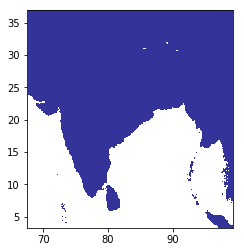

There are 5 urban boundaries lost! Because some boundaries are too small for the pixel size of the raster!
Therefore upsampling the raster!


In [5]:
with rasterio.open('out/pm25_india', "w", **out_meta) as dest:
        dest.write(out_img)
# Open the clipped raster file
clipped = rasterio.open('pm25_india')

# Uncomment to visualize in notebook
show((clipped, 1), cmap='terrain')

urban_stats = zonal_stats("ind_urban_boundary/ind_urban_boundary.shp", "pm25_india",
            stats="count min mean max median", geojson_out=True)
collection = FeatureCollection(urban_stats)
gdf_urban_stats = gpd.GeoDataFrame.from_features(collection['features'])
lost_urban = gdf_urban_stats[gdf_urban_stats['mean'].isna()].shape[0]
print(f'There are {lost_urban} urban boundaries lost! Because some boundaries are too small for the pixel size of the raster!')

print('Therefore upsampling the raster!')

### Upsampling the raster and then using zonal stats

In [6]:
src =  rasterio.open("out/pm25_india")
print(src.shape)
data = src.read(
        out_shape=(src.height * 15, src.width * 15),
        resampling=Resampling.bilinear
    )
print(data.shape)

aff = src.transform

newaff = Affine(aff.a / 15, aff.b, aff.c,
                aff.d, aff.e / 15, aff.f)

out_meta.update({'width':data.shape[2],'height':data.shape[1],'transform':newaff})
with rasterio.open('pm25_india_upsampled', "w",**out_meta) as dest:
        dest.write(data)

urban_stats = zonal_stats("out/ind_urban_boundary/ind_urban_boundary.shp", "out/pm25_india_upsampled",
            stats="count min mean max median", geojson_out=True)
collection = FeatureCollection(urban_stats)
gdf_urban_stats = gpd.GeoDataFrame.from_features(collection['features'])
lost_urban = gdf_urban_stats[gdf_urban_stats['mean'].isna()].shape[0]
print(f'Finally there are {lost_urban} urban boundaries lost! Because some boundaries are too small for the pixel size of the raster!')

gdf_urban_stats = gdf_urban_stats[~gdf_urban_stats['mean'].isna()]
print(f'Total {len(gdf_urban_stats)} urban boudaries with avg PM25 values ')

(336, 319)
(1, 5040, 4785)
Finally there are 5 urban boundaries lost! Because some boundaries are too small for the pixel size of the raster!
Total 4028 urban boudaries with avg PM25 values 


### Plotting histogram and saving output

/home/rts/.local/lib/python3.6/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


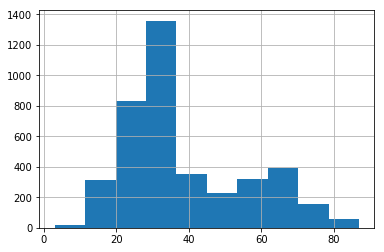

In [7]:
df = gdf_urban_stats[['URBID','mean']]
df.rename(columns={'mean':'PM2.5'},inplace=True)
df.to_csv('out/ind_urban_boundary_pm25.csv',index=False)
ax = df['PM2.5'].hist()  
fig = ax.get_figure()
fig.savefig('out/pm25_india_histogram.pdf')